In [ ]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.preprocessing import image
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install visualkeras
!pip install ann_visualizer
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ann_visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4167 sha256=d3eeaa338150753c720544b00ca46903f4a38b59c7b85e39c3a82fa3331fbe4a
  Stored in directory: /root/.cache/pip/wheels/6e/0f/ae/f5dba91db71b1b32bf03d0ad18c32e86126093aba5ec6b6488
Successfully built ann_visualizer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_folder = '/content/drive/MyDrive/fire_dataset'
train_data_folder = '/content/drive/MyDrive/fire_dataset/fire_images'
test_date_folder  = '/content/drive/MyDrive/fire_dataset/non_fire_images'

categories = ['fire_images', 'non_fire_images']
len_categories = len(categories)

In [ ]:
image_count = {}
train_data = []

for i , category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    label = category
    image_count[category] = []

    for path in os.listdir(os.path.join(class_folder)):
        image_count[category].append(category)
        train_data.append(['{}/{}'.format(category, path), i, category])

2it [00:00, 86.87it/s]


In [ ]:
#create a dataframe
df = pd.DataFrame(train_data, columns=['file', 'id', 'label'])
df.shape
df.head()

file  id        label
0   fire_images/fire.10.png   0  fire_images
1  fire_images/fire.100.png   0  fire_images
2    fire_images/fire.1.png   0  fire_images
3  fire_images/fire.101.png   0  fire_images
4  fire_images/fire.103.png   0  fire_images

In [ ]:
#masking function
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([0,0,250])
    upper_hsv = np.array([250,255,255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

#image segmentation function
def segment_image(image, mask):
    output = cv2.bitwise_and(image, image, mask=mask)
    return output / 255  # Normalize to the range [0, 1]

#sharpen the image
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

# function to get an image
def read_img(path, size):
    img = image.load_img(os.path.join(data_folder, path), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

In [ ]:
# Function to preprocess an image
def preprocess_image(image_path, size=(255, 255)):
    # Read the image
    img = read_img(image_path, size)

    # Create mask for plant
    mask = create_mask_for_plant(img)

    # Segment the image
    segmented_image = segment_image(img, mask)

    # Sharpen the segmented image
    sharpened_image = sharpen_image(segmented_image)

    return img, mask, segmented_image, sharpened_image


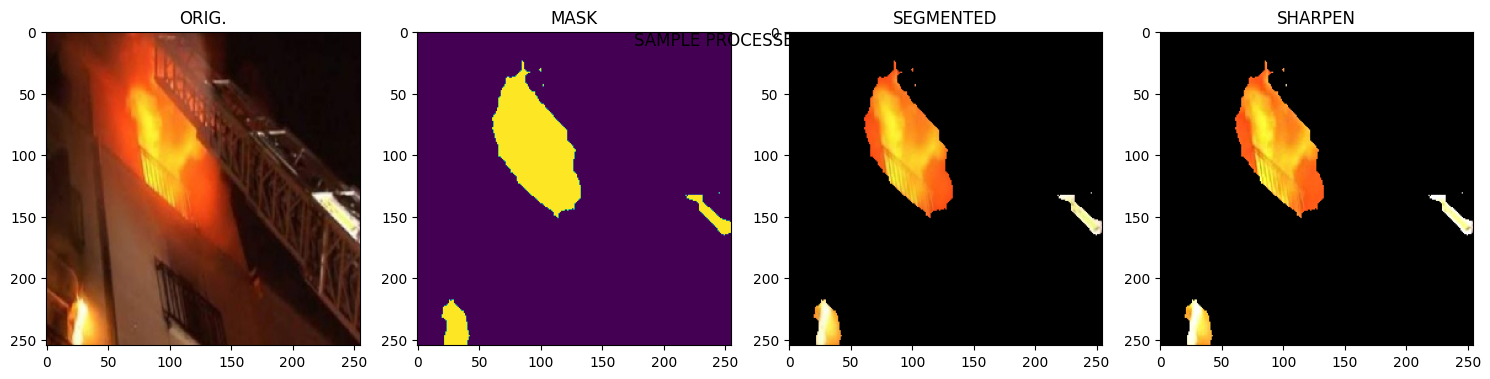

In [ ]:
# Function to display a set of images
def display_images(images, titles):
    fig, ax = plt.subplots(1, len(images), figsize=(15, 5))
    plt.suptitle('SAMPLE PROCESSED IMAGE', x=0.5, y=0.8)
    plt.tight_layout()

    for i in range(len(images)):
        ax[i].set_title(titles[i], fontsize=12)
        ax[i].imshow(images[i])

# Example usage
image_path = df['file'][102]  # Replace with your actual image path
img, mask, segmented_image, sharpened_image = preprocess_image(image_path)

# Display the images
display_images([img/255, mask, segmented_image, sharpened_image], ['ORIG.', 'MASK', 'SEGMENTED', 'SHARPEN'])

In [ ]:
train_data_dir = data_folder
batch_size = 32
target_size = (224, 224)
validation_split = 0.2
train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=200,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=44,
    image_size=target_size,
    batch_size=batch_size,
)

Found 999 files belonging to 2 classes.
Using 800 files for training.
Found 999 files belonging to 2 classes.
Using 199 files for validation.


**<a id="3"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px">Visualization of Dataset </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [ ]:
class_names = train.class_names
class_names

['fire_images', 'non_fire_images']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Assuming 'data' is your feature data, and 'labels' is your label data
# Example: data = pd.read_csv('your_data.csv')
#         labels = data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Plot the distribution of labels in the training set
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Training Set Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')

# Plot the distribution of labels in the testing set
plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Testing Set Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


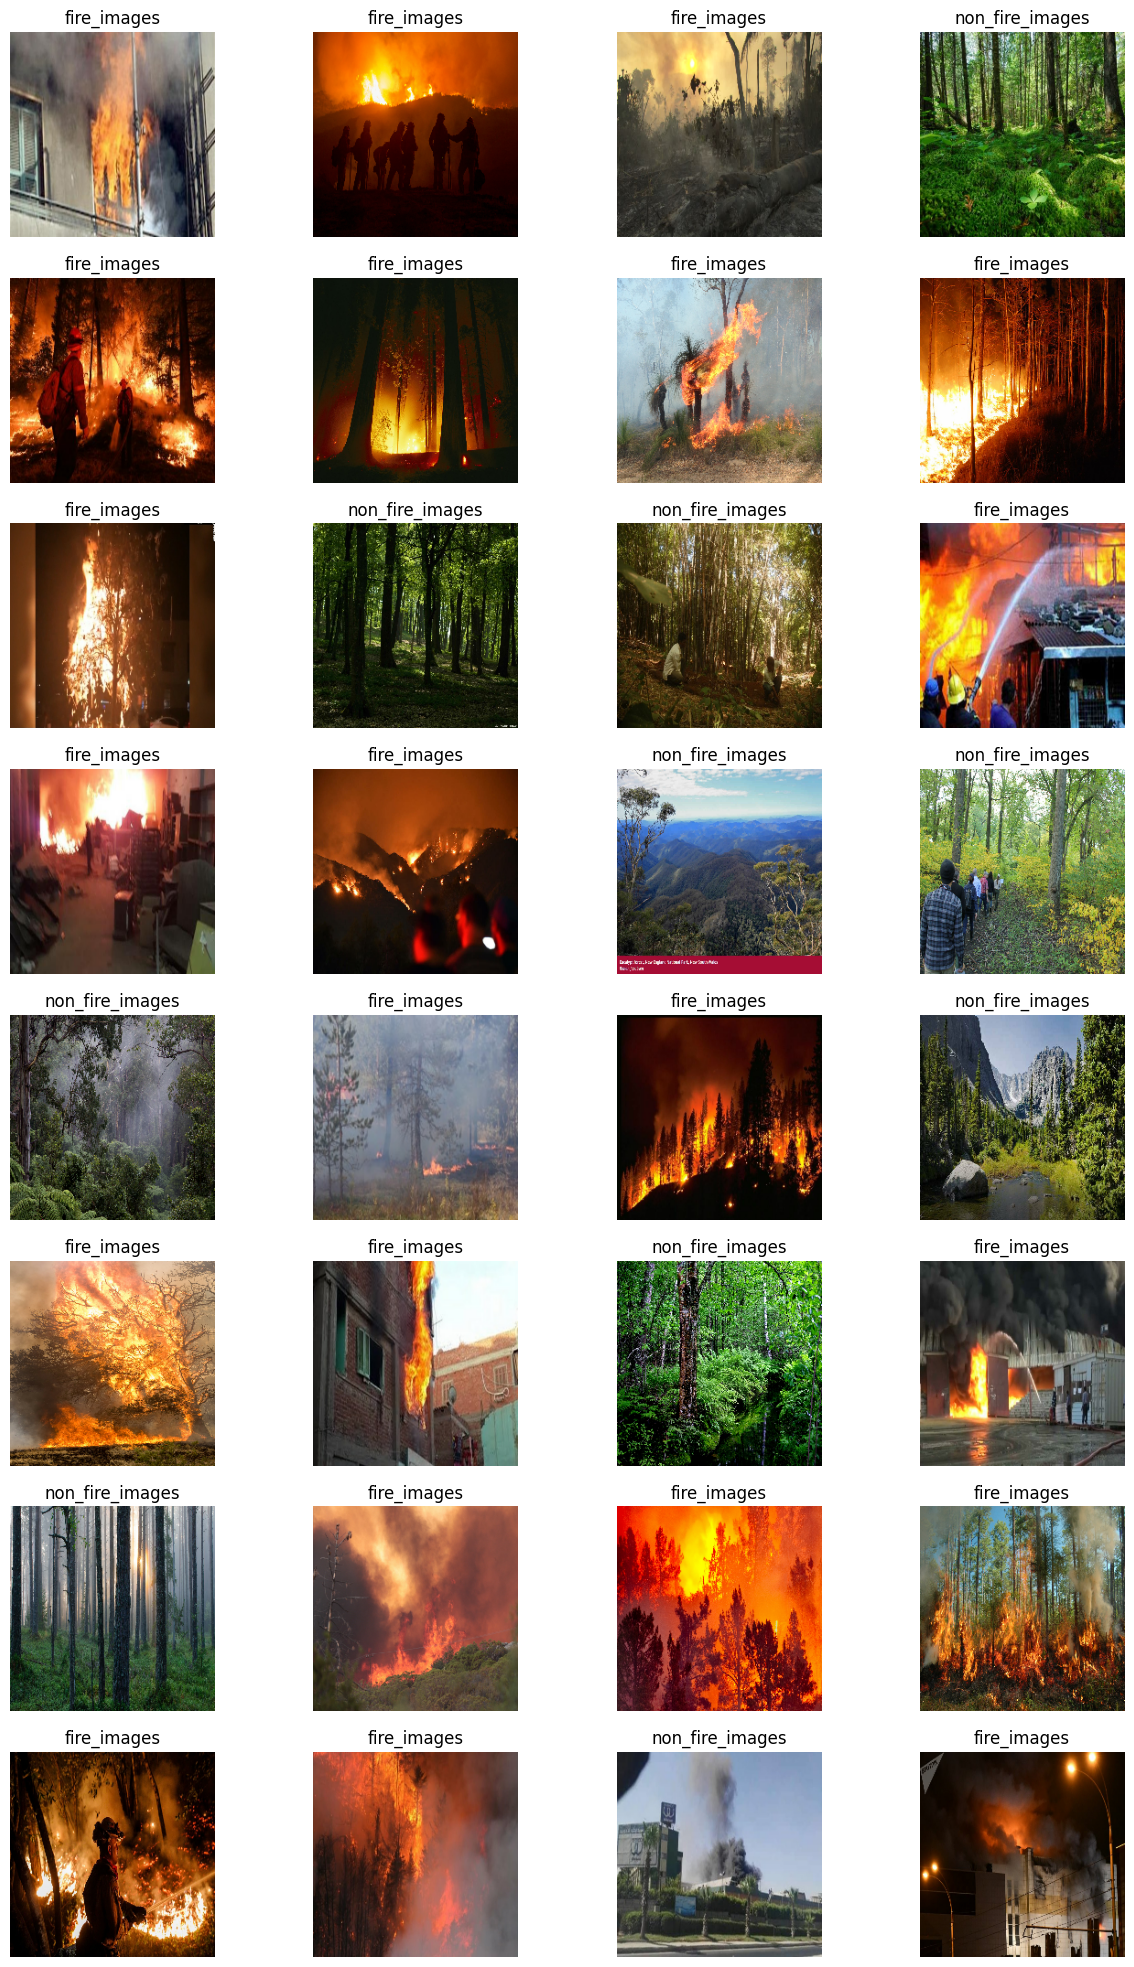

In [ ]:
plt.figure(figsize=(15, 25))
for images, labels in train.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a id="4"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [ ]:
base_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
model=keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(1,activation=tf.nn.sigmoid))
model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


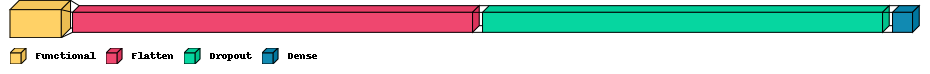

In [ ]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

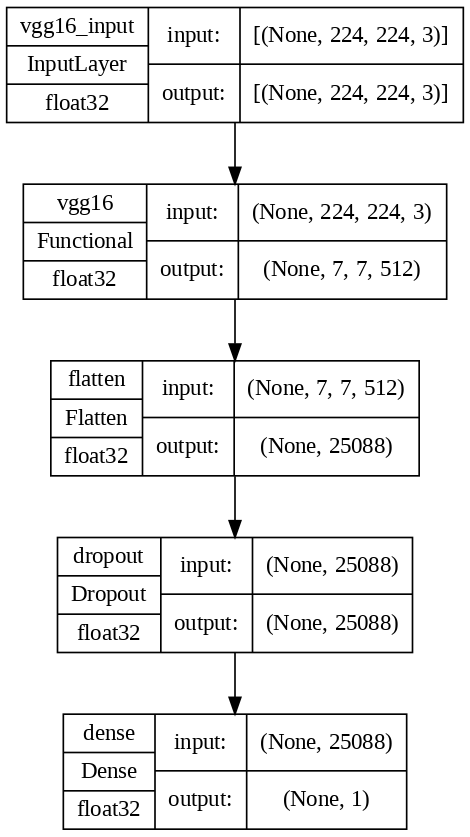

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [ ]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=3, restore_best_weights=True)
model.compile(optimizer ='adam',loss='binary_crossentropy', metrics=['accuracy'])
hist=model.fit_generator(train,epochs=5,validation_data=validation,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/5
25/25 [==============================] - 65s 1s/step - loss: 1.6704 - accuracy: 0.8650 - val_loss: 0.4320 - val_accuracy: 0.9548
Epoch 2/5
25/25 [==============================] - 20s 668ms/step - loss: 0.2738 - accuracy: 0.9787 - val_loss: 0.2927 - val_accuracy: 0.9648
Epoch 3/5
25/25 [==============================] - 21s 710ms/step - loss: 0.0516 - accuracy: 0.9850 - val_loss: 0.2590 - val_accuracy: 0.9799
Epoch 4/5
25/25 [==============================] - 22s 678ms/step - loss: 0.0293 - accuracy: 0.9912 - val_loss: 0.2717 - val_accuracy: 0.9849
Epoch 5/5
25/25 [==============================] - 20s 670ms/step - loss: 0.0570 - accuracy: 0.9912 - val_loss: 0.2519 - val_accuracy: 0.9849


In [ ]:
score, acc = model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

7/7 [==============================] - 6s 121ms/step - loss: 0.2519 - accuracy: 0.9849
Test Loss = 0.2518737018108368
Test Accuracy = 0.9849246144294739


In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  val_loss  val_accuracy
0  1.670417   0.86500  0.432022      0.954774
1  0.273802   0.97875  0.292731      0.964824
2  0.051583   0.98500  0.259019      0.979900
3  0.029344   0.99125  0.271653      0.984925
4  0.056983   0.99125  0.251874      0.984925

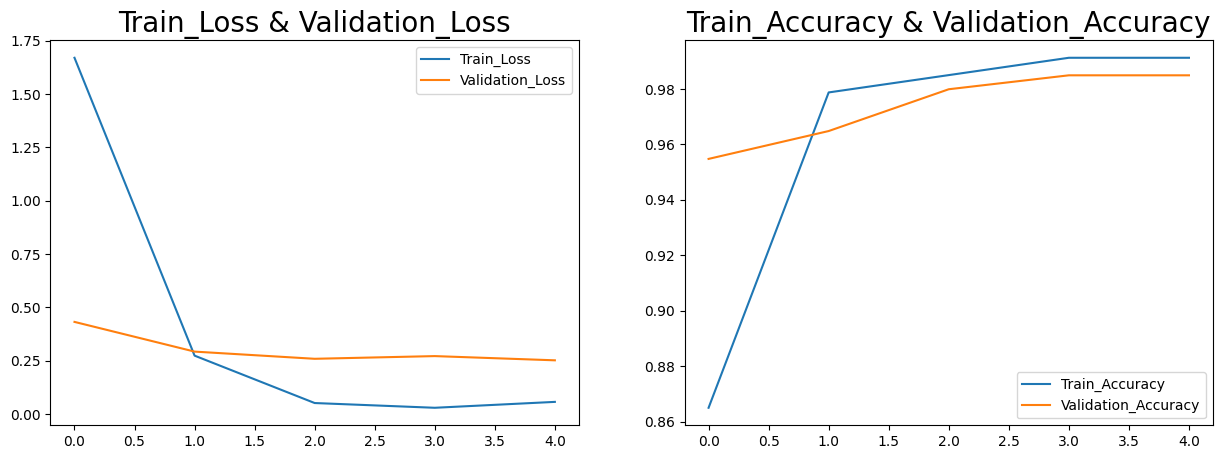

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [ ]:
X_val,y_val=[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=model.predict(np.array(X_val))
y_pred=np.where(predictions>=.5,1,0)
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

7/7 [==============================] - 1s 131ms/step


Actual  Prediction
0         0           0
1         0           0
2         1           1
3         0           0
4         0           0
..      ...         ...
194       0           0
195       0           0
196       0           0
197       1           1
198       0           0

[199 rows x 2 columns]

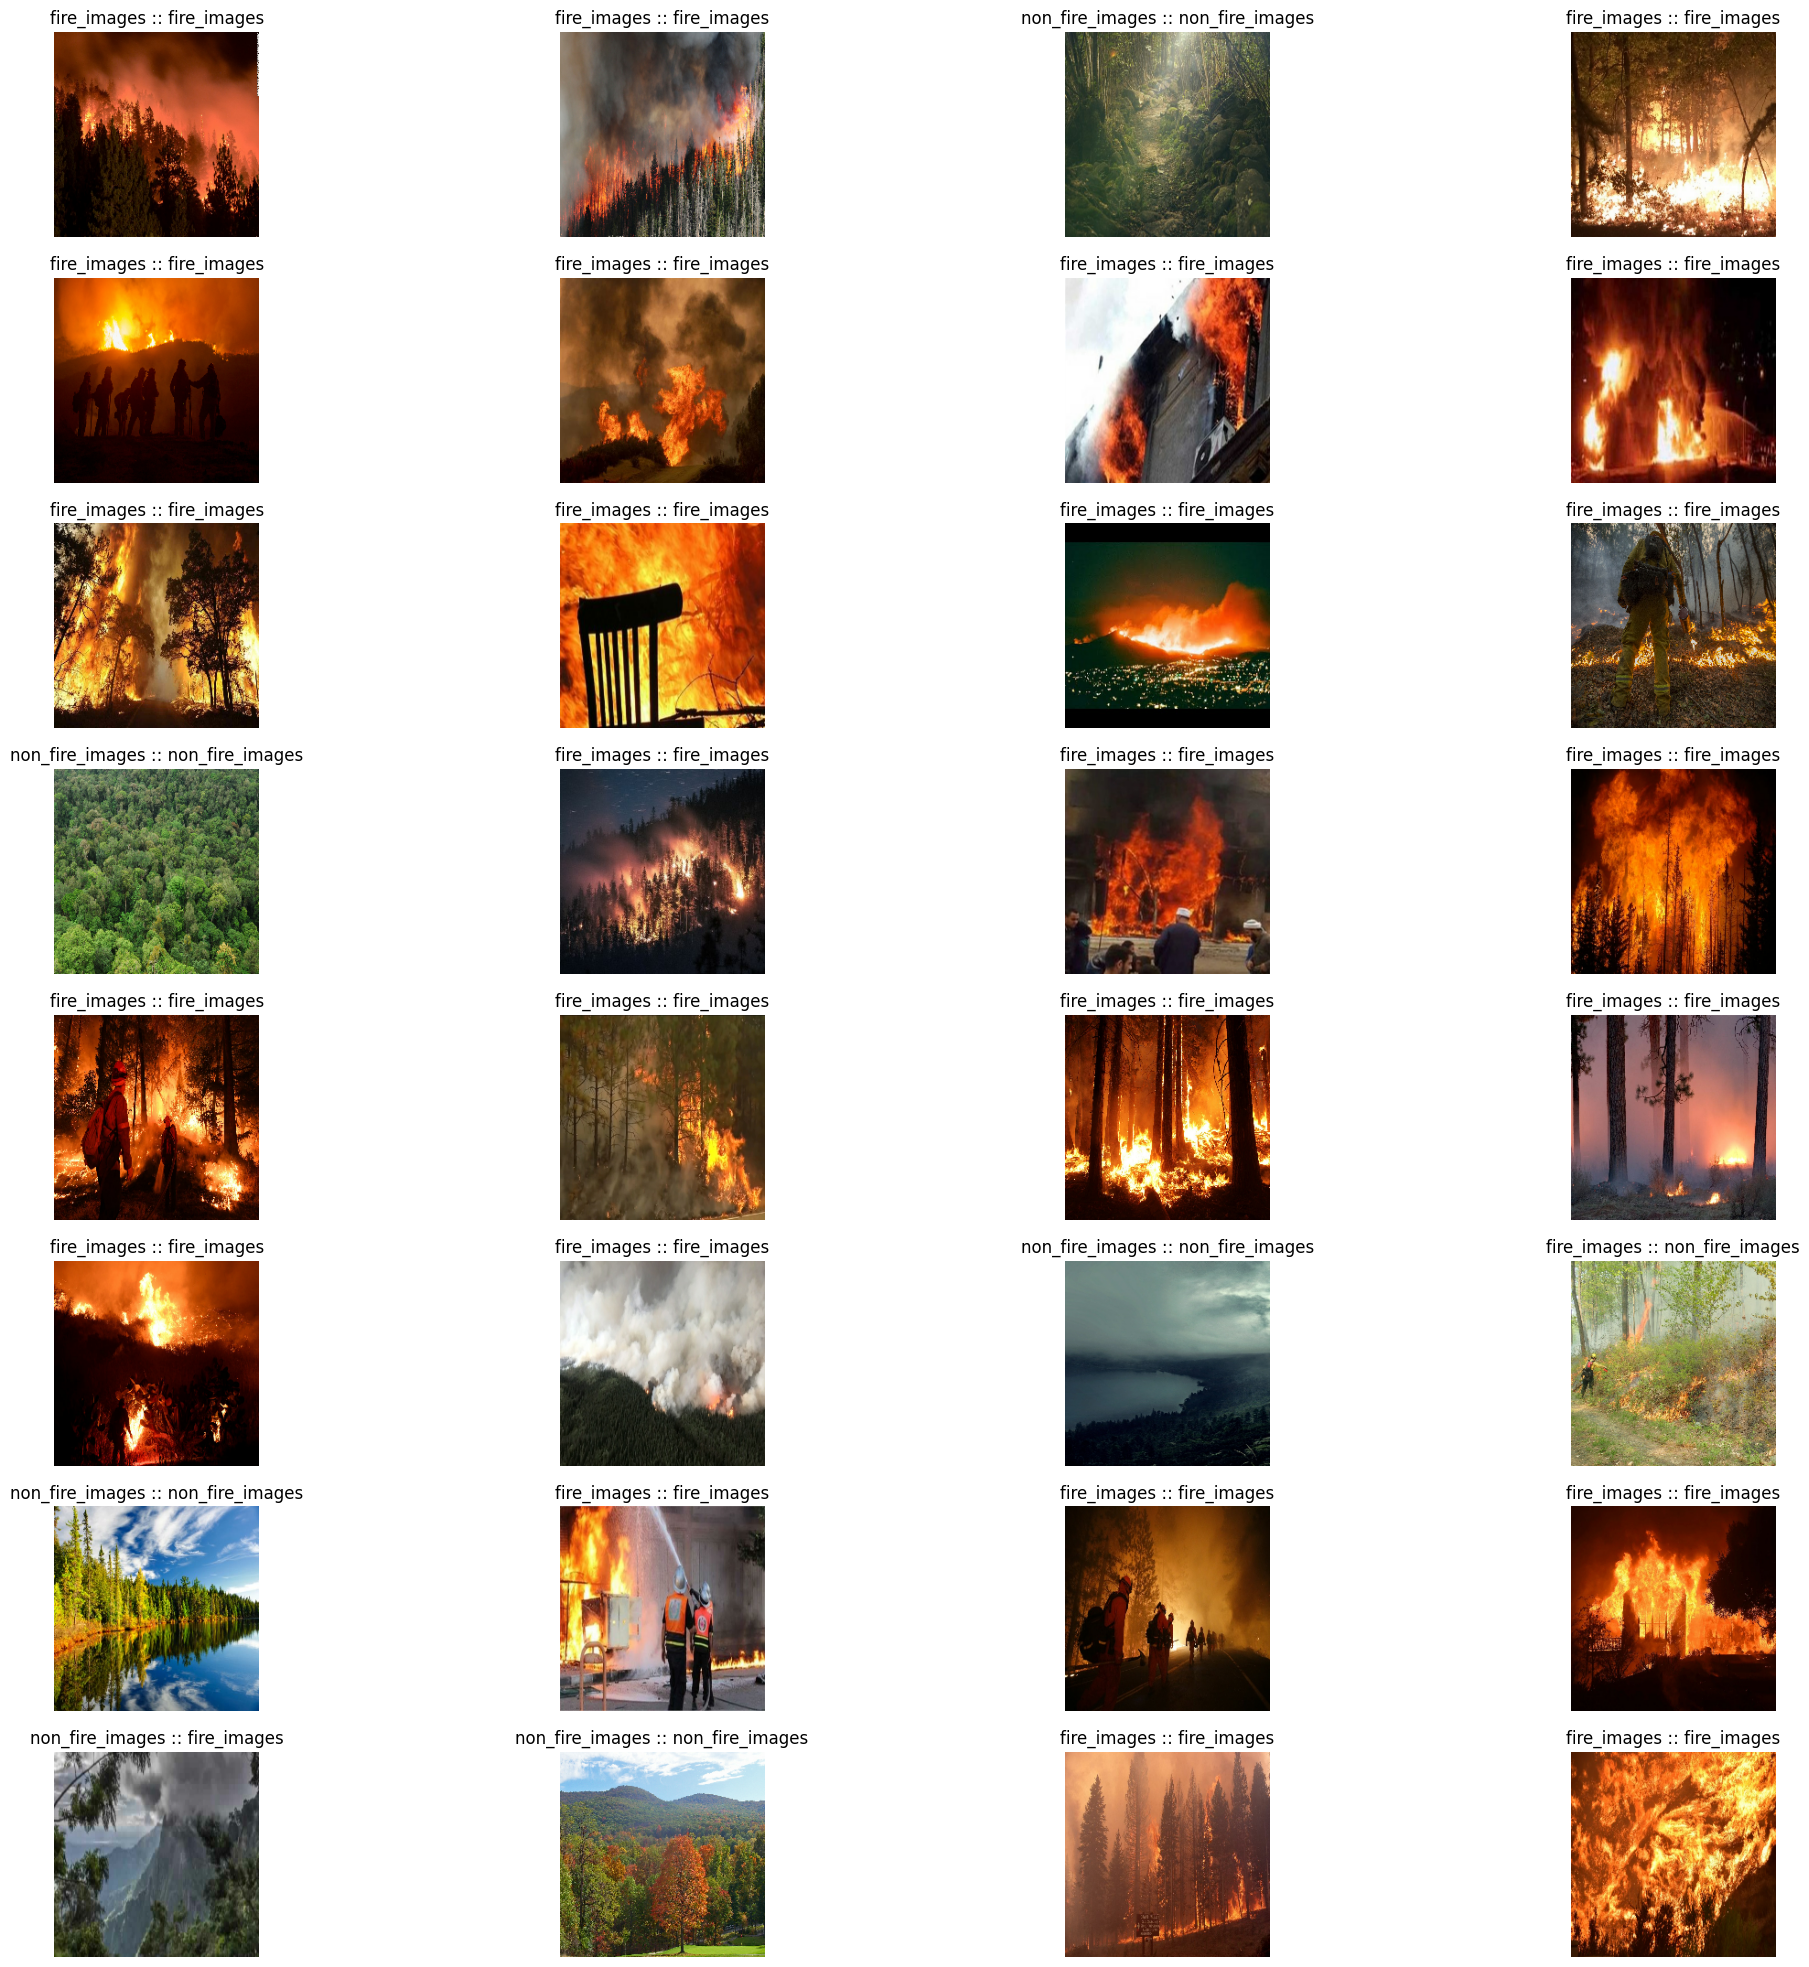

In [ ]:
plt.figure(figsize=(25,25))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i][0]]}')
    plt.axis("off")

<a id="5"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Evaluate The Model  </p>
<a class="btn" href="#home">Tabel of Contents</a>

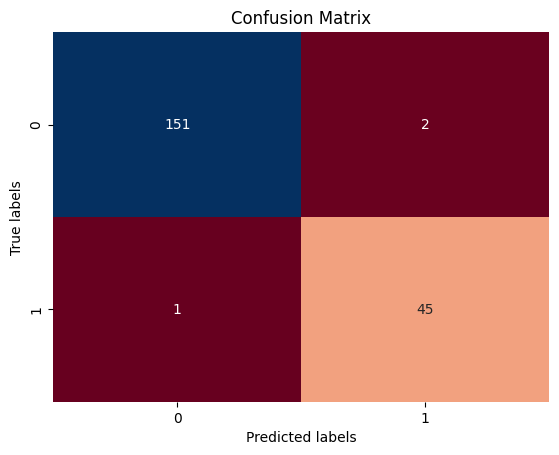

array([[151,   2],
       [  1,  45]])

In [ ]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

In [ ]:
ClassificationReport = classification_report(y_val,y_pred)
print(ClassificationReport )

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       153
           1       0.96      0.98      0.97        46

    accuracy                           0.98       199
   macro avg       0.98      0.98      0.98       199
weighted avg       0.99      0.98      0.98       199

